In [1]:
import random, time, os, pytz, argparse, yaml, sys
os.chdir("../scripts/controlled_probing")

In [2]:
sys.path.append("../")
sys.path.append("../probing")
import numpy as np
from probing.probe import *
from tqdm import tqdm, trange
from probing_utils import *
from controlled_splits_dataset import *
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
def heatmap(data, 
            y_label, x_label, 
            ax=None,
            cbar_kw=None, 
            cbarlabel="", 
            **kwargs
    ):

    if ax is None: ax = plt.gca()
    if cbar_kw is None: cbar_kw = {}
    im = ax.imshow(data, aspect="auto", **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    step = data.shape[1] // 10
    x_ticks = np.arange(0, data.shape[1], step)
    y_ticks = np.arange(0, data.shape[0], step)
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.spines[:].set_visible(False)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar



In [3]:
ckpts_dir = "ckpts/"
ckpt_handle = "1206_161348"
with open(os.path.join(ckpts_dir, ckpt_handle, "configs.yaml"), 'rb') as f: config = yaml.full_load(f.read()) # dict


In [4]:
with open(config['nouns_file'], "r") as f: 
    nouns = [l.strip() for l in f.readlines()]
noun2id = {n:i for i, n in enumerate(nouns)}
if "max_num_nouns" in config: nouns = nouns[:config['max_num_nouns']]
train_texts, test_texts = eval(f"create_data_{config['split_method']}")(nouns)
test_data = Controlled_Splits(test_texts)
print(f'Number of testing examples: {len(test_data)}')
test_dl = DataLoader(test_data, shuffle=False, batch_size=config['batch_size'])

print("Prepare Data: finish\n")

Number of testing examples: 3480
Prepare Data: finish



In [9]:
train_sentences = [x[0] for x in train_texts]
test_sentences = [x[0] for x in test_texts]


In [19]:
nouns[53], nouns[45] 

('helicopter', 'belt')

In [22]:
"a belt is at the bottom of a helicopter." in train_sentences

False

In [8]:
train_texts[0]

('a soda is on top of a backpack.', tensor([0]))

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss().to(device)

model = PROBE(
    hidden_dim_multipliers = config['hidden_dim_multipliers'], 
    num_classes = 2, 
    lm = config['lm'], 
    lm_kwargs = config['lm_kwargs']
).to(device)

load_from_path = os.path.join(ckpts_dir, ckpt_handle, "model.pt")
model.load_state_dict(torch.load(load_from_path))
print(f"Load ckpt from {load_from_path}")

Load ckpt from ckpts/1115_113950/model.pt


In [17]:

model.eval()
epoch_loss, epoch_acc = 0, 0

l = config['max_num_nouns'] if 'max_num_nouns' in config else len(nouns)
confusion_matrix = np.zeros((l*2, l))

with torch.no_grad():
    for (texts, labels) in tqdm(test_dl, desc="Validating", mininterval=10):

        output = model(list(texts)) # batch_size*2, num_classes

        gth = torch.cat([labels, 1 - (labels % 2) + 2*(labels // 2)], dim=1).long().view((-1,)).to(device)
        
        for idx, text in enumerate(texts):
            #print(text)
            n1, n2 = text.split()[1], text.split()[-1].replace(".", "")
            if 'at the bottom of' in text:
                r = 1 
                i, j = noun2id[n2], noun2id[n1]
            else:
                r = 0
                i, j = noun2id[n1], noun2id[n2]
            #print(i, j, r)
            sample_output = output[idx*2:(1+idx)*2]
            sample_gth = gth[idx*2:(1+idx)*2]

            loss = criterion(sample_output, sample_gth)
            acc = get_acc(sample_output, sample_gth)

            confusion_matrix[i*2+r][j] += loss

            epoch_loss += loss.item()
            epoch_acc += acc
    
test_loss, test_acc =  epoch_loss/len(test_data), epoch_acc/len(test_data)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
print()

Validating: 100%|██████████| 189/189 [00:03<00:00, 51.80it/s]

Test Loss: 1.296 | Test Acc: 66.47%



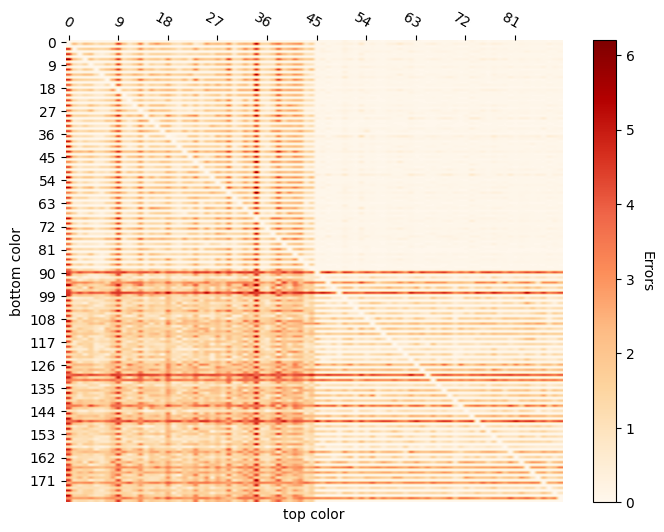

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im, cbar = heatmap(confusion_matrix, 
                   "bottom color", "top color",
                   ax=ax, cmap="OrRd", cbarlabel="Errors")
#texts = annotate_heatmap(im, valfmt="{x:.1f}")
plt.show()